# Traffic simulation
In this exercise, using two datasets, I will be calculating and plotting two things:
1. The speed of two vehicles based on their locations at specific points in time (+ max speed/ min speed)
2. The exact moment and between which vehicles a collision occurred based on their speed at specific points in time
(+ locations of vehicles at specific points in time) <br>

Starting with the loading in of the two datasets:

In [1]:
import csv

def read_file(file_path):
    with open(file_path) as car_file:
        file_reader = csv.reader(car_file, delimiter=";")
        data = dict()
        time = list()
        for row in file_reader:
            for i in range(1, len(row)):
                data["Car {}".format(i)] = [float(row[i])]
            break
        for row in file_reader:
            time.append(float(row[0]))
            for i in range(1, len(row)):
                data["Car {}".format(i)].append(float(row[i]))
    return data, time


## 1. The speed of two vehicles:
The basic formula of speed is as follows: <br>
$v_{avg} = \dfrac{\Delta x}{\Delta t}$ <br>
$v_{avg} = \dfrac{|x_{1} - x_{0}|}{t_{1}-t_{0}}$<br>
Meaning, speed is the difference in space divided by the difference in time. <br>
In this dataset, the smallest difference in time you is 0.1 seconds. $\Delta t$ is thus always assumed as 0.1.
While usually you can achieve a negative (going backwards) I have chosen for the purposes of this script to 
take the absolute difference in space. This ensures that speed is always positive.

Car 1 max: 6.3500000000004775 min: 1.269999999999527
Car 2 max: 2.0000000000000284 min: 0.0


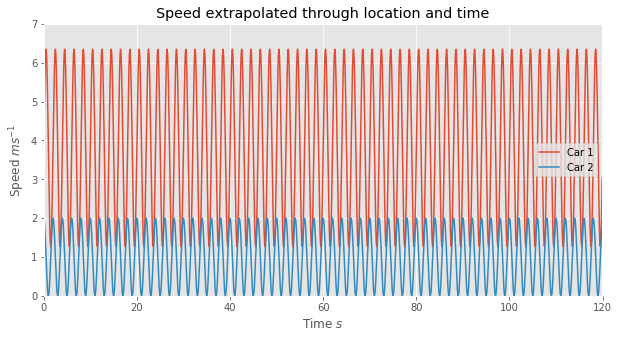

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style
plt.rcParams['figure.figsize'] = [10,5]
style.use('ggplot')
def calculate_speed():
    positions_calculated_speeds = dict()
    positions, time = read_file("verkeerssimulatie-rechteweg-posities.csv")

    for car in positions:
        positions_calculated_speeds[car] = {"list": list()}
        for location_index in range(1, len(positions[car])):
            # difference in location divided by difference in time
            positions_calculated_speeds[car]["list"].append(abs(positions[car][location_index] -
                                                                    positions[car][location_index - 1]) / 0.1)
        # Per car get max and min speed
        positions_calculated_speeds[car]["max"] = max(positions_calculated_speeds[car]["list"])
        positions_calculated_speeds[car]["min"] = min(positions_calculated_speeds[car]["list"])
        print(car, "max:",positions_calculated_speeds[car]["max"], "min:",positions_calculated_speeds[car]["min"])
        # Plot speeds per car
        plt.plot(time, positions_calculated_speeds[car]["list"], label=car)

    plt.axis([min(time), max(time), 0, 7])
    plt.legend()
    plt.title("Speed extrapolated through location and time")
    plt.ylabel('Speed $m s^{-1}$')
    plt.xlabel('Time $s$')
    plt.show()

calculate_speed()

## The positions of three vehicles and when they collide
Location:<br>
$l_{current} \leftarrow$ current location, $s \leftarrow$ difference in space in space <br>
$l_{current} = l_{previous}  + s$ <br>
$s = v t$ <br>
$l_{current} = l_{previous} + vt$ 
#### For example:
The location of car 1 at 0.1 seconds: <br>
$s = 0.38 \times 0.1 = 0.381 $m <br>
$l_{previous} = 0$ <br>
$l_{current} = 0 + 0.381 = 0.381$<br>

---

Below, these calculations are done for every 0.1 seconds in the dataset. <br>
You'll find two plots:
- difference in space over 120 seconds
- difference in space over 1 second. <br>
The reason for plotting the latter separately from the other is that the collision happen in that time frame.
It is, however, very hard to see over the full 120 seconds. 


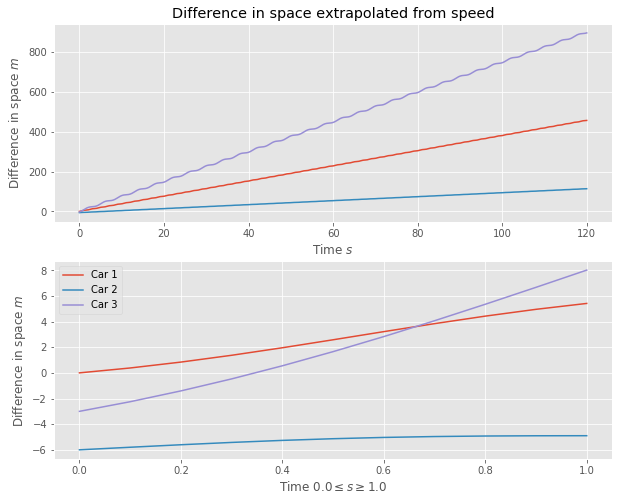

In [3]:
%matplotlib inline
def find_position():
    style.use('ggplot')
    plt.rcParams['figure.figsize'] = [10,8]
    speeds, time = read_file("verkeerssimulatie-rechteweg-snelheden.csv")
    positions = dict()
    
    for car in speeds:
        positions[car] = [speeds[car].pop(0)]
        for i in speeds[car][:-1]:
            # location = old location + speed * time
            speed = i
            difference_in_space = speed * 0.1
            location = positions[car][-1] + difference_in_space
            positions[car].append(location)
    plt.figure(1)
    plt.subplot(211)
    for car in positions:
        plt.plot(time, positions[car], label=car)
    plt.title( "Difference in space extrapolated from speed")
    plt.ylabel('Difference in space $m$')
    plt.xlabel('Time $s$')
    plt.subplot(212)
    for car in positions:
        plt.plot(time[:11], positions[car][:11], label=car)
    plt.ylabel('Difference in space $m$')
    plt.xlabel('Time $0.0 \leq s \geq 1.0$')
    plt.legend()
    plt.show()
    
    return positions, time
positions, time = find_position()

In latter plot, you can clearly see that somewhere between 0.6 and 0.8 that Car 1 and Car 2 intersect. The specific 
moment these two vehicles collide, is when the absolute distance between them is equal or smaller than 2 meters.


In [4]:
def find_collision(positions, time):
    collisions = dict()
    for car in positions:
        positions_minus_car = positions.copy()
        positions_minus_car.pop(car)
        # For all possible combinations of car (Car 1 + Car 2, Car 1 + Car 3, etc)
        for second_car in positions_minus_car:
            least_distance = abs(positions[car][0] - positions[second_car][0])
            for time_index in range(len(positions[car])):
                next_distance = abs(positions[car][time_index] - positions[second_car][time_index])
                # If distance between cars at current point is smaller than previously smallest distance
                if next_distance < least_distance:
                    # Set smallest distance to latest distance
                    least_distance = next_distance
                    # If the distance between cars is 2 meters or less, there's a collision.
                    if least_distance <= 2:
                        collisions[car + ";" + second_car] = time_index
                        # break

    for collision in collisions:
        keys = collision.split(";")
        print(
    "A collision occurred between cars {} and {} at {} seconds".format(keys[0], keys[1],
                                                                       time[collisions[collision]])) 
find_collision(positions, time)

A collision occurred between cars Car 1 and Car 3 at 0.7 seconds
A collision occurred between cars Car 3 and Car 1 at 0.7 seconds


# Extras: 
### Problem with find_collision()
The function 'find_collision' only saves the last moment of impact, not the first one. If you were to uncomment the
break on line 144, the first moment of impact is saved instead. It would also be possible to save these moments of 
impact in a list.

### Velocity vs. Speed
For the purposes of this assignment, the term *speed* was used instead of *velocity*. This was done for one good reason:
The difference in space in these datasets was monodirectional and always positive. This means that the cars always moved in one
direction.  
Speed is a scalar property, which entails that it is a force *without* direction.  
Velocity is a vector quality, which entails that it is a force *with* direction.   
Direction was irrelevant for this assignment. Thus, speed was the more suited term.
